In [1]:
import os 

import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy.linalg as sla

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../plots/'

from pypower import BaseMatrix
from emulator_fit import get_power_likelihood
from wmatrix_utils import plot_matrix

tracer = 'ELG'
region = 'SGC'
completeness = 'complete_'
stat = 'power'
theory_name = 'velocileptors'
rp_cut = 2.5
xinmax = True
solve = True
fc = ''
imock = None
direct = False

ells = [0, 2, 4]

In [2]:
#data_dir = '/global/cfs/cdirs/desi/users/mpinon/'
data_dir = '/Users/mp270220/Work/fiber_collisions/'

In [3]:
wm = BaseMatrix.load(os.path.join(data_dir, 'windows/wm_mock0_ELG_complete_SGC.npy'))
wm_rpcut = BaseMatrix.load(os.path.join(data_dir, 'windows/wm_mock0_ELG_complete_SGC_rp2.5.npy'))
w = wm_rpcut.deepcopy()

# in
kinrebin = 10
w.slice_x(slicein=slice(0, len(w.xin[0]) // kinrebin * kinrebin, kinrebin))
w.select_x(xinlim=(0.005, 0.35))

# out
klim = {0: [0.02, 0.2, 0.005], 2: [0.02, 0.2, 0.005], 4: [0.02, 0.2, 0.005]}
factorout = 5
for iout, projout in enumerate(w.projsout):
    w.slice_x(sliceout=slice(0, len(w.xout[iout]) // factorout * factorout, factorout), projsout=projout)
w.select_x(xoutlim=klim[0][:2])

In [4]:
emulator_dir = os.path.join(data_dir, 'emulators/emulators_shapefit_{}'.format(tracer))
emulator_fn = os.path.join(emulator_dir, 'power_xinmax0.35_{}.npy')
footprint_fn = os.path.join(emulator_dir, 'footprint_{}.npy')
likelihood = get_power_likelihood(tracer=tracer, region=region, completeness=completeness, theory_name=theory_name, fc=fc, rp_cut=rp_cut, direct=direct, emulator_fn=emulator_fn, footprint_fn=footprint_fn, solve=False)

footprint


/Users/mp270220/anaconda3/lib/python3.10/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [5]:
params = dict(b1=0.3)

In [6]:
likelihood(**params)

-381.76856243453733

In [37]:
cov = likelihood.observables[0].covariance
theory = np.array(likelihood.observables[0].wmatrix.theory.power).flatten()
data = np.array(likelihood.observables[0].wmatrix.power).flatten()

In [101]:
likelihood.observables[0].wmatrix.theory.power[2].max()

1435.7645079500057

In [102]:
likelihood.observables[0].wmatrix.theory.power[2].min()

-24.137591053812432

In [8]:
np.array(likelihood.observables[0].wmatrix.theory.power).flatten()

array([13046.67358262, 13143.11687027, 13239.77275046, ...,
         -20.50215408,   -22.32490659,   -24.13759105])

In [9]:
shotnoise = likelihood.observables[0].shotnoise.flat[0]

In [10]:
#likelihood.observables[0].init.update(data=likelihood.observables[0].flattheory, shotnoise=likelihood.observables[0].shotnoise.flat[0])
#likelihood(**params)

In [11]:
def get_t(wmatrix, idces, ells):
    nells = len(ells)

    idces = list(idces)

    t = np.zeros((wmatrix.shape[0], nells))
    for idx in idces:
        for i in range(nells):
            t[i * (wmatrix.shape[0]  // nells) + idx][i] = 1
    return t

In [12]:
def aprime(a, w, idces, ells):
    t = get_t(w, idces, ells)
    w = w.value.T
    tmp = (w.dot(t)).T.dot(a).dot(w.dot(t))
    tmpinv = np.linalg.inv(tmp)
    tmp2 = t.dot(tmpinv).dot(t.T)
    anew = (a @ w.dot(tmp2).dot(w.T) @ a)
    return a - anew

In [13]:
invcov = np.linalg.inv(cov)
idces = [-1]

anew = aprime(invcov, w, idces, ells)

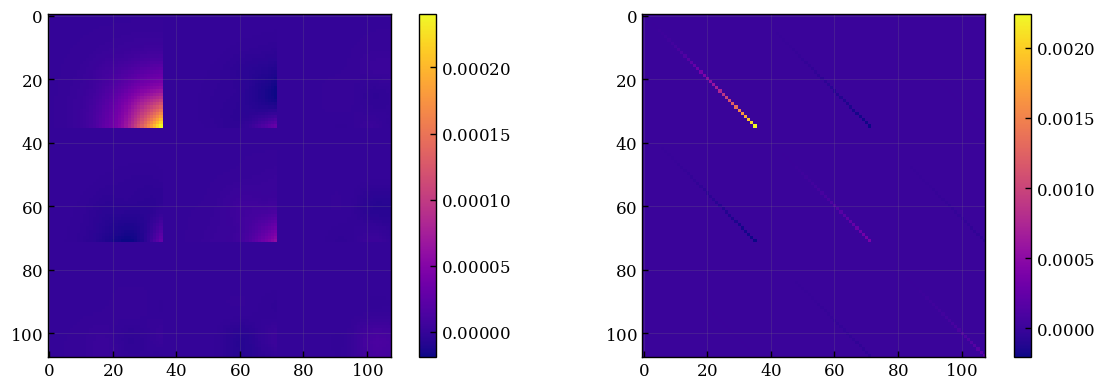

In [14]:
fig, lax = plt.subplots(1, 2, figsize=(12, 4))

cmap = lax[0].imshow(invcov - anew)
fig.colorbar(cmap)
cmap = lax[1].imshow(invcov)
fig.colorbar(cmap)

plt.show()

In [15]:
lda, m = sla.eig(anew)
lda, m

(array([ 2.20851580e-03+0.j,  2.03340473e-03+0.j,  1.87423461e-03+0.j,
         1.72548724e-03+0.j,  1.58330528e-03+0.j,  1.44500128e-03+0.j,
         1.30916547e-03+0.j,  1.17623603e-03+0.j,  1.04798533e-03+0.j,
         9.27121828e-04+0.j,  8.16855941e-04+0.j,  7.18774079e-04+0.j,
         6.33179843e-04+0.j,  5.59036690e-04+0.j,  4.94209039e-04+0.j,
         4.35963535e-04+0.j,  3.81702463e-04+0.j,  3.77767684e-04+0.j,
         3.45418430e-04+0.j,  3.29404377e-04+0.j,  3.16107436e-04+0.j,
         2.88905462e-04+0.j,  2.78730774e-04+0.j,  2.63077057e-04+0.j,
         2.38480242e-04+0.j,  2.30461767e-04+0.j,  2.14796470e-04+0.j,
         1.95852908e-04+0.j,  1.90609417e-04+0.j,  1.86156666e-04+0.j,
         1.77596783e-04+0.j,  1.69527693e-04+0.j,  1.60979476e-04+0.j,
         1.50366097e-04+0.j,  1.47593619e-04+0.j,  1.45040912e-04+0.j,
         1.33089180e-04+0.j,  1.29178125e-04+0.j,  1.16128785e-04+0.j,
         1.18378533e-04+0.j,  1.13453803e-04+0.j,  1.04871966e-04+0.j,
      

In [16]:
mk = m.copy()
lda[lda < 1e-15] = 0
np.where(lda==0)

(array([105, 106, 107]),)

In [17]:
mk[:, lda==0] = 0

In [18]:
wnew = m.dot(mk.T).dot(w.value.T)

In [19]:
wnew.shape

(108, 1194)

In [20]:
wmatrixnew = w.deepcopy()
wmatrixnew.value = wnew.T

/var/folders/w4/r_7221jx0dd2t1c5nq01bdpxhl18w8/T/ipykernel_11260/2885708681.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(plots_dir, 'wmatrix_rpcut_marginalized.png'), dpi=300)
/Users/mp270220/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


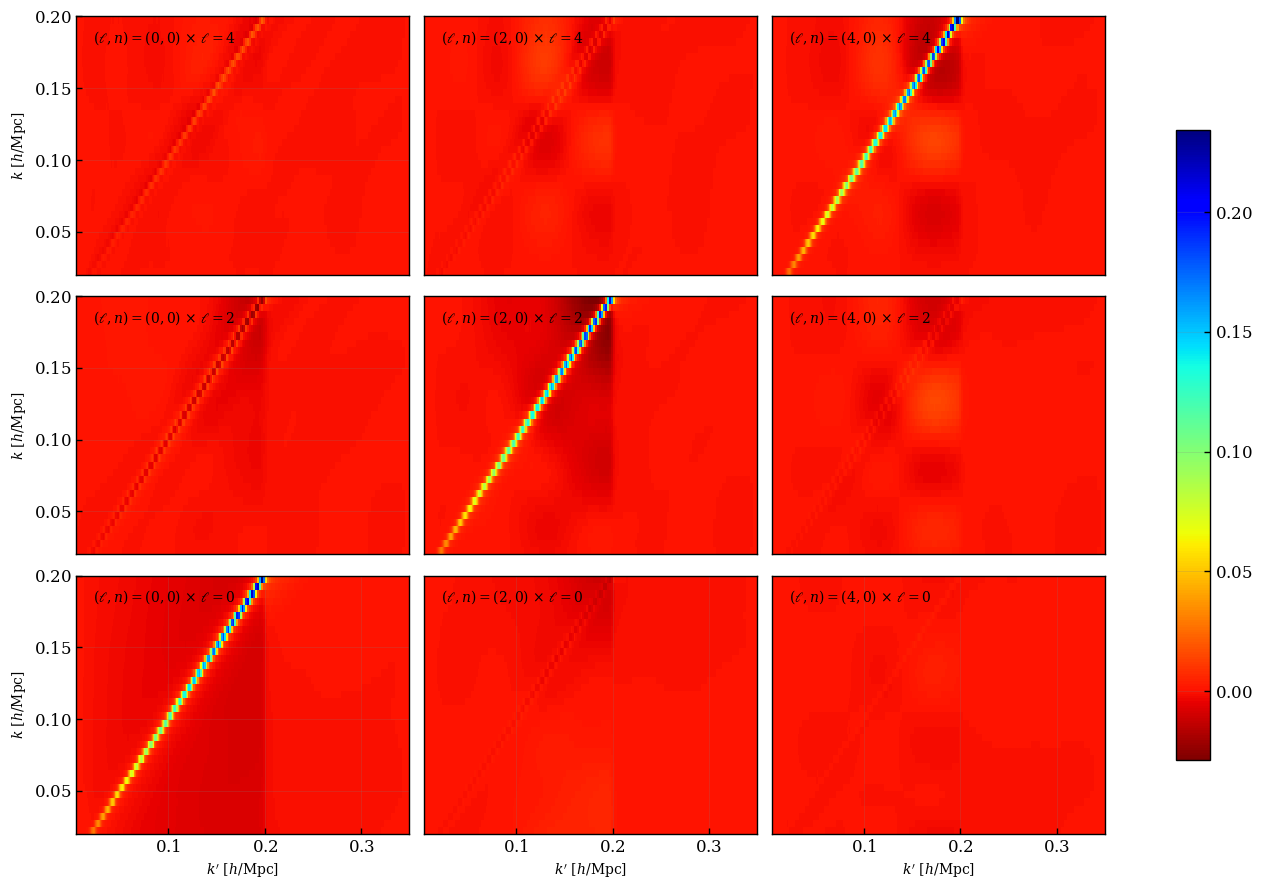

In [21]:
norm = Normalize(vmin=0, vmax=1)

plot_matrix(wmatrixnew.unpacked(), x1=wmatrixnew.xin, x2=wmatrixnew.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[proj.latex(inline=True) for proj in wmatrixnew.projsin], label2=[proj.latex(inline=True) for proj in wmatrixnew.projsout])
plt.savefig(os.path.join(plots_dir, 'wmatrix_rpcut_marginalized.png'), dpi=300)
plt.show()

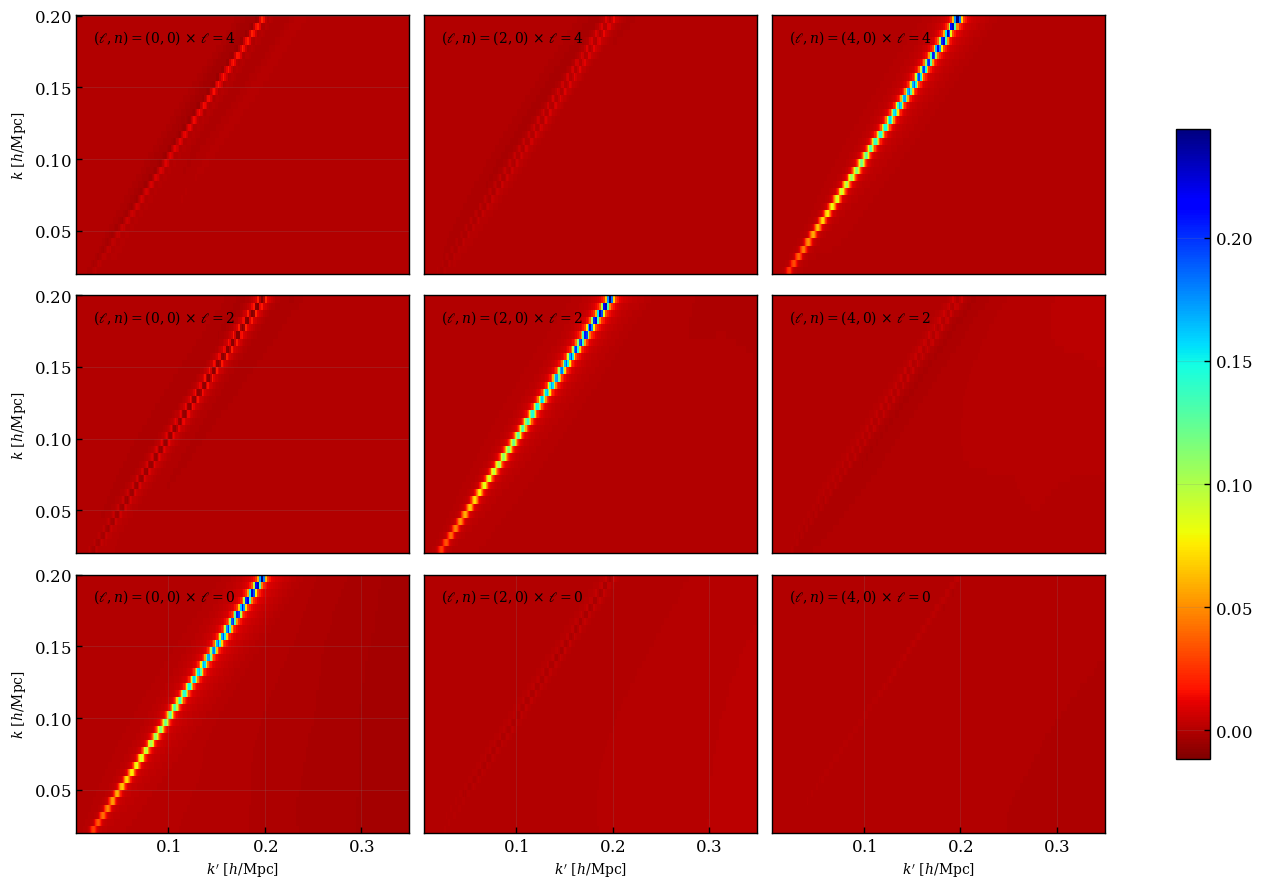

In [22]:
from matplotlib.colors import Normalize

plot_matrix(w.unpacked(), x1=w.xin, x2=w.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[proj.latex(inline=True) for proj in w.projsin], label2=[proj.latex(inline=True) for proj in w.projsout])
plt.show()

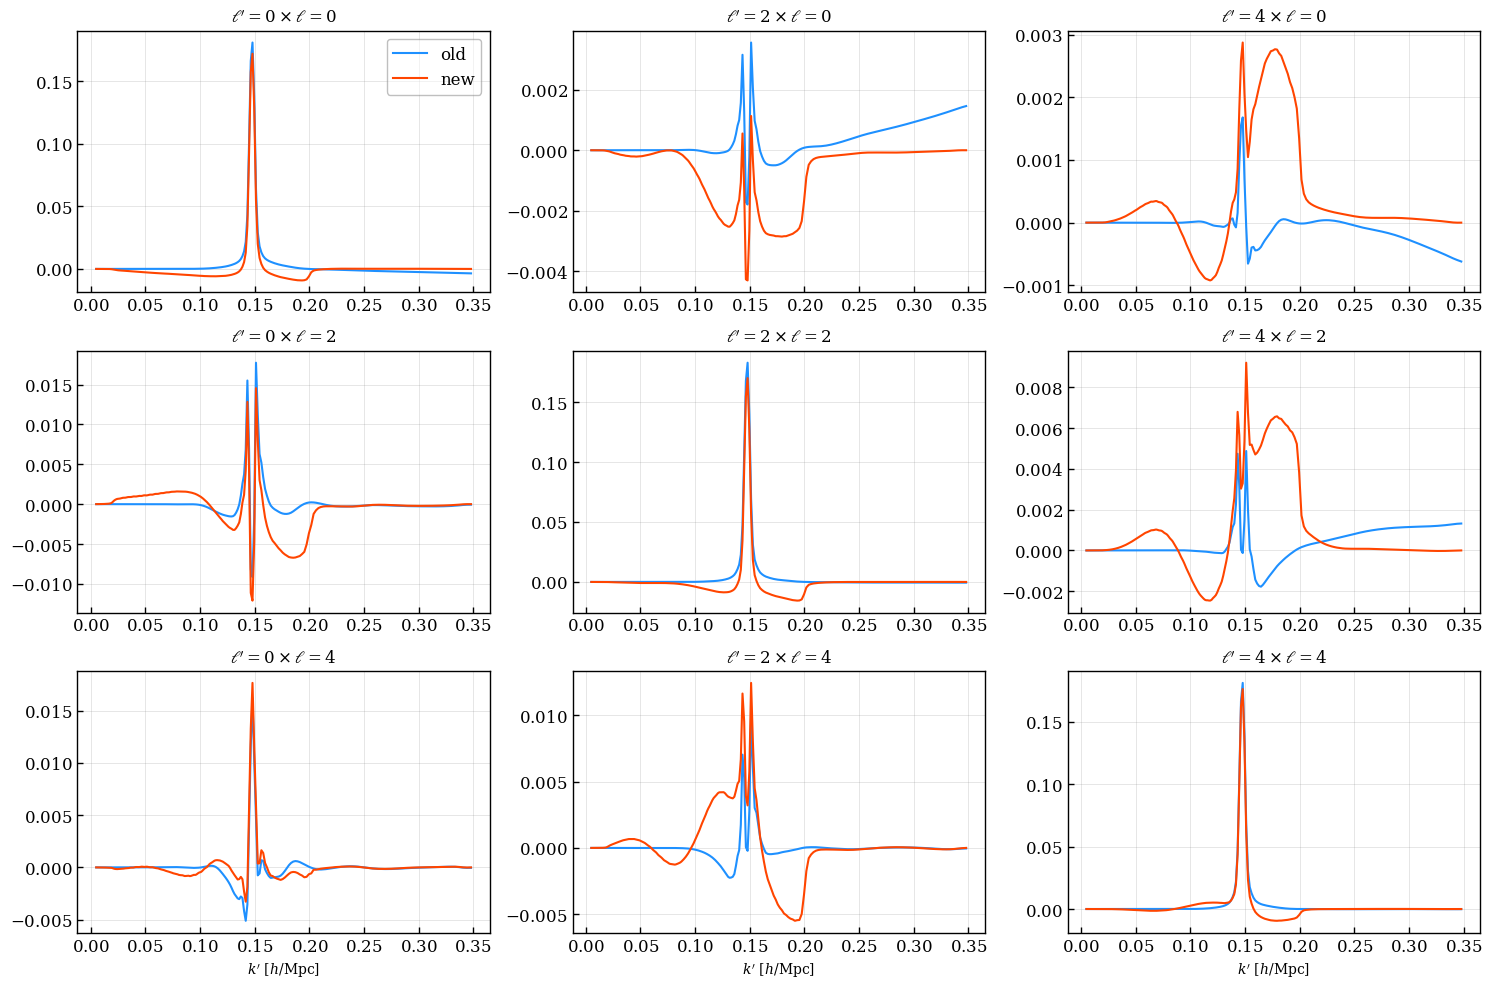

In [23]:
kval = 0.15
indexout = np.abs(w.xout[0] - kval).argmin()

fig, lax = plt.subplots(len(w.projsout), len(w.projsin), figsize=(15, 10))
for iin, projin in enumerate(w.projsin):
    for iout, projout in enumerate(w.projsout):
        if np.asarray(lax).ndim > 0:
            ax = lax[iout][iin]
        else:
            ax = lax
        # Indices in approximative window matrix
        norm = 1.
        ax.plot(w.xin[iin], w.unpacked()[iin][iout][:, indexout] / norm, label='old', color='dodgerblue')
        ax.plot(w.xin[iin], wmatrixnew.unpacked()[iin][iout][:, indexout] / norm, color='orangered', label='new')
        ax.set_title(r'$\ell^\prime = {:d} \times \ell = {:d}$'.format(projin.ell, projout.ell))
        ax.grid(True)
        if iout == len(w.projsout) - 1: ax.set_xlabel(r'$k^{\prime}$ [$h/\mathrm{Mpc}$]')
        if iin == iout == 0: ax.legend()
#plt.savefig(os.path.join(plots_dir, 'wmatrix_rpcut_marginalized_fixedk_koutmax0.25.png'), dpi=300)
plt.show()

In [131]:
def chisquare(data, theory, w, invcov, shotnoise=None, ells=(0, 2, 4)):
    d = data.copy()
    th = theory.copy()
    if shotnoise is not None:
        nells = len(ells)
        d[:len(d) // nells] += shotnoise
        th[:len(th) // nells] += shotnoise
    wm = w.value.T
    tmp = d - wm.dot(th)
    #print(tmp)
    res = tmp.T @ invcov @ tmp
    return res


def new_chisquare(data, theory, w, invcov, ells, theta, idces, shotnoise=None):
    d = data.copy()
    th = theory.copy()
    if shotnoise is not None:
        nells = len(ells)
        d[:len(d) // nells] += shotnoise
        th[:len(th) // nells] += shotnoise
 
    anew = aprime(invcov, w, idces, ells)
    lda, m = sla.eig(anew)
    mk = m.copy()
    lda[lda < 1e-15] = 0
    mk[:, lda==0] = 0
    wnew = w.deepcopy()
    wnew.value = (m.dot(mk.T).dot(w.value.T)).T
    
    m0 = m - mk
    #t0 = m @ m0.T @ d
    #dnew = d - t0
    dnew = m.dot(mk.T).dot(d)
    t0 = d - dnew
    t = get_t(w, idces, ells)
    tnew = th - np.sum(theta * t, axis=1)
    
    res = chisquare(d - t0, tnew, wnew, invcov, shotnoise=None, ells=ells)

    return res

In [132]:
chisq = chisquare(data, theory, w, invcov, shotnoise)
chisq

0.0

In [133]:
new_chisq = new_chisquare(data, theory, w, invcov, ells = [0, 2, 4], theta = np.array([0, 0, 0]), idces = [-1], shotnoise=shotnoise) 
new_chisq

8.408588293335565e-25

In [134]:
theta_vals = np.linspace(-1000, 1000, 100)

chisquares_vals = [new_chisq for tha in theta_vals]
new_chisquares_vals1 = [new_chisquare(data, theory, w, invcov, ells = [0, 2, 4], theta = np.array([tha, 0, 0]), idces = [-1], shotnoise=shotnoise) for tha in theta_vals]
new_chisquares_vals2 = [new_chisquare(data, theory, w, invcov, ells = [0, 2, 4], theta = np.array([0, tha, 0]), idces = [-1], shotnoise=shotnoise) for tha in theta_vals]
new_chisquares_vals3 = [new_chisquare(data, theory, w, invcov, ells = [0, 2, 4], theta = np.array([0, 0, tha]), idces = [-1], shotnoise=shotnoise) for tha in theta_vals]

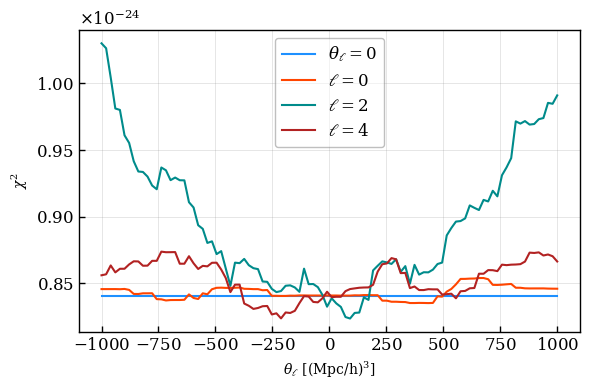

In [136]:
plt.plot(theta_vals, chisquares_vals, label=r'$\theta_{\ell} = 0$')
plt.plot(theta_vals, new_chisquares_vals1, label=r'$\ell = 0$')
plt.plot(theta_vals, new_chisquares_vals2, label=r'$\ell = 2$')
plt.plot(theta_vals, new_chisquares_vals3, label=r'$\ell = 4$')
plt.xlabel(r'$\theta_{\ell}$ [$(\mathrm{Mpc/h})^3$]')
plt.ylabel(r'$\chi^2$')
plt.legend()
plt.show()

In [29]:
m0 = m - mk
t0 = m @ m0.T @ data
new_data = data - t0 - wnew.dot(theory)

In [30]:
anew = aprime(invcov, w, idces, ells)

In [31]:
covnew = np.linalg.inv(anew)

In [32]:
from desilike.likelihoods import ObservablesGaussianLikelihood
new_likelihood = ObservablesGaussianLikelihood(observables=[new_data], covariance=covnew)

In [33]:
new_likelihood()

PipelineError: Error in method initialize of <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x178617bb0>